In [ ]:
# External libraries used for various tasks in later parts of the code
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import xml.etree.ElementTree as ET
from torch.utils.data import Dataset
from imutils import paths
import torch
import torch.nn as nn
import time
import numpy as np
import torch.optim as optim
from tqdm.notebook import tqdm
import os

# Check if running on Google Colab and set the data paths accordingly
is_running_on_colab = 'COLAB_GPU' in os.environ
if is_running_on_colab:
    from google.colab import drive
    drive.mount('/content/gdrive')
    data_path = '/content/gdrive/MyDrive/license_plate/data/'
    test_path = '/content/gdrive/MyDrive/license_plate/testdata/'
else:
    current_dir = os.getcwd()
    data_path = os.path.join(current_dir, 'dataset', 'license_plate', 'data')
    test_path = os.path.join(current_dir, 'dataset', 'license_plate', 'test_data')

# Function to check if directories exist
def check_directories_exist(*paths):
    for path in paths:
        assert os.path.isdir(path), f"The directory {path} does not exist."

# Check the directories
check_directories_exist(data_path, test_path)

data_link = "https://drive.google.com/open?id=1rdEsCUcIUaYOVRkx5IMTRNA7PcGMmSgc"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
from torch.utils.data import Dataset
import cv2
from imutils import paths
import os
import torch

class LabelFpsDataLoader(Dataset):
    def __init__(self, img_dirs, img_size, is_transform=None):
        self.img_paths = [p for img_dir in img_dirs for p in paths.list_images(img_dir)]
        self.img_size = img_size
        self.is_transform = is_transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, index):
        img_name = self.img_paths[index]
        img = cv2.imread(img_name)
        resized_image = self.transform_image(img)

        file_name = os.path.splitext(os.path.basename(img_name))[0]
        labels = self.extract_labels(file_name, img.shape)

        return resized_image, labels, img_name

    def transform_image(self, img):
        resized_image = cv2.resize(img, self.img_size).astype('float32') / 255.0
        # print(resized_image.dtype)
        # Normalization - Adjust mean and std if necessary
        mean = np.array([0.485, 0.456, 0.406], dtype=resized_image.dtype)
        std = np.array([0.229, 0.224, 0.225],dtype=resized_image.dtype)

        resized_image = (resized_image - mean) / std  # Normalize
        # print(resized_image.dtype)
        return resized_image

    def extract_labels(self, file_name, img_shape):
        parts = file_name.split('-')
        points = [self.parse_point(part) for part in parts[2].split('_')]
        ori_w, ori_h = img_shape[1], img_shape[0]
        scale_w, scale_h = self.img_size[0] / ori_w, self.img_size[1] / ori_h
        scaled_points = [(int(x * scale_w), int(y * scale_h)) for x, y in points]
        flattened_labels = [coord for point in scaled_points for coord in point]
        return torch.tensor(flattened_labels, dtype=torch.float32)

    @staticmethod
    def parse_point(point_str):
        return tuple(int(coord) for coord in point_str.split('&'))


In [ ]:
# Initialize your dataset
img_dirs = [data_path]  # Replace with actual paths to your image directories
img_size = (224, 224)  # Replace with your desired image size
dataset = LabelFpsDataLoader(img_dirs=img_dirs, img_size=img_size)  # Use 'img_dirs' as the correct argument name

# Test the length of the dataset
print(f"Length of dataset: {len(dataset)}")
#
# Test getting an item
try:
    # Retrieve the first item
    img, labels, img_name = dataset[0]

    # Check the shapes and types
    print(f"Image shape: {img.shape}")
    print(f"Labels: {labels}")
    print(f"Image name: {img_name}")

    # If the code reaches this point, the item has been retrieved successfully
    print("Item retrieval successful.")
except Exception as e:
    # If there is any error, print it out
    print(f"An error occurred: {e}")
finally:
    print("Got out here")


Length of dataset: 427
Image shape: (224, 224, 3)
Labels: tensor([100.,  98., 129., 104.])
Image name: /content/gdrive/MyDrive/license_plate/data/0036-0_1-323&509_417&541-416&541_323&540_324&509_417&510-0_0_27_14_24_24_29-63-24.jpg
Item retrieval successful.
Got out here


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def plot_img_and_boundingbox(image, labels):
    # Assuming image is a PyTorch tensor, we need to first move it to CPU if it's on GPU,
    # then detach it from the current graph, convert to numpy, and finally transpose it
    # from (channels, height, width) to (height, width, channels)
    numpy_array = image.cpu().detach().numpy()

    # Convert from BGR to RGB format if the image was read by OpenCV
    rgb_image = cv2.cvtColor(numpy_array, cv2.COLOR_BGR2RGB)

    # Extract numerical values from tensors and convert to integers
    left_up = (int(labels[0]), int(labels[1]))
    right_down = (int(labels[2]), int(labels[3]))

    # Draw rectangle on the image
    new_image = cv2.rectangle(rgb_image, left_up, right_down, (255, 0, 0), 2)

    # Display the image
    plt.imshow(new_image)
    plt.axis('off')  # Hide the axis
    plt.show()

# Example usage:
# img, labels, _ = dataset[0]  # Assuming this is how you get an image and labels from your dataset
# plot_img_and_boundingbox(img, labels)


In [ ]:
import torch
import torch.nn as nn


# Function to create the modified classifier
def create_custom_classifier(input_features, hidden_units, output_features):
    classifier = nn.Sequential(
        nn.Linear(input_features, hidden_units),
        nn.ReLU(),
        nn.Dropout(0.0),
        #nn.BatchNorm1d(hidden_units),
        nn.Linear(hidden_units, output_features),
    )
    return classifier

# Load a pre-trained MobileNetV3 model
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v3_large', pretrained=True)

# Replace the classifier with a new one - adjust the input_features to match the last layer of MobileNetV3
model.classifier = create_custom_classifier(input_features=960, hidden_units=100, output_features=4)
#Sets model to training mode,e this is important for layers that have different functionalities depending on training or eval. for example BatchNorm
model.train()
def get_new_model():
    model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v3_large', pretrained=True)
    model.classifier = create_custom_classifier(input_features=960, hidden_units=100, output_features=4)
    model.train()
    # Number of layers you want to fine-tune
    layers_of_classifier = len(model.classifier)

    # Get all the parameters from the model as a list
    parameters = list(model.parameters())

    # The total number of layers is the length of the parameters list
    number_of_layers = len(parameters)
    print(f"Total number of layers is {number_of_layers}")

    # Calculate the number of pretrained layers (all except the last 'layers_of_classifier')
    pretrained_layers = number_of_layers - layers_of_classifier
    print(f"Number of pretrained base layers is {pretrained_layers}")

    # Freeze the parameters of the pretrained base layers
    for param in parameters[:-layers_of_classifier]:
        param.requires_grad = False

    # Unfreeze the parameters of the last 'layers_of_classifier' layers
    for param in parameters[-layers_of_classifier:]:
        param.requires_grad = True
    return model



Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [ ]:
# Number of layers you want to fine-tune
layers_of_classifier = len(model.classifier)

# Get all the parameters from the model as a list
parameters = list(model.parameters())

# The total number of layers is the length of the parameters list
number_of_layers = len(parameters)
print(f"Total number of layers is {number_of_layers}")

# Calculate the number of pretrained layers (all except the last 'layers_of_classifier')
pretrained_layers = number_of_layers - layers_of_classifier
print(f"Number of pretrained base layers is {pretrained_layers}")

# Freeze the parameters of the pretrained base layers
for param in parameters[:-layers_of_classifier]:
    param.requires_grad = False

# Unfreeze the parameters of the last 'layers_of_classifier' layers
for param in parameters[-layers_of_classifier:]:
    param.requires_grad = True

Total number of layers is 174
Number of pretrained base layers is 170


In [ ]:
def check_requires_grad():
  for name, param in model.named_parameters(): # Just to check
    if name.startswith('classifier'):
        print(f'Layer {name} - requires_grad: {param.requires_grad}')
    if name.startswith('features'):
        print(f'Layer {name} - requires_grad: {param.requires_grad}')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# check_requires_grad()

In [ ]:
# from datetime import datetime
# def bb_intersection_over_union(boxA, boxB): # https://pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
# 	# determine the (x, y)-coordinates of the intersection rectangle
# 	xA = max(boxA[0], boxB[0])
# 	yA = max(boxA[1], boxB[1])
# 	xB = min(boxA[2], boxB[2])
# 	yB = min(boxA[3], boxB[3])
# 	# compute the area of intersection rectangle
# 	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
# 	# compute the area of both the prediction and ground-truth
# 	# rectangles
# 	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
# 	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
# 	# compute the intersection over union by taking the intersection
# 	# area and dividing it by the sum of prediction + ground-truth
# 	# areas - the interesection area
# 	iou = interArea / float(boxAArea + boxBArea - interArea)
# 	# return the intersection over union value
# 	return iou

# def calculate_true_positives_in_batch(y_pred, y_batch):
#   threshold = 0.5
#   true_positive_amount = 0
#   for i in range(y_pred.shape[0]):
#     y_pred_numpy = y_pred[i].cpu().detach().numpy()
#     y_batch_numpy = y_batch[i].cpu().detach().numpy()
#     iou = bb_intersection_over_union(y_pred_numpy, y_batch_numpy)
#     if iou > threshold:
#       true_positive_amount +=1
#   return true_positive_amount

# #wrapper of tqdm to enable toggling it off easily
# def toggle_tqdm(iterable, use_tqdm=True):
#   if use_tqdm:
#     return tqdm(iterable)
#   else:
#     return iterable

# def calculate_loss_and_accuracy(loader):
#   total_loss = 0
#   total_true_positives = 0
#   total_samples = 0

#   for X_batch_, y_batch, img_name in loader:
#       X_batch = X_batch_.permute(0,3,1,2).to(device)
#       y_batch = y_batch.to(device)
#       y_pred = model(X_batch)

#       total_true_positives += calculate_true_positives_in_batch(y_pred, y_batch)

#       loss = loss_fn(y_pred, y_batch)
#       total_loss += loss.item() * len(y_batch)  # Accumulate scaled loss
#       total_samples += len(y_batch)  # Accumulate number of samples
#   sample_loss = total_loss / total_samples  # Calculate average loss
#   accuracy = total_true_positives / total_samples
#   return sample_loss, accuracy

# def save_model(model):
#   # Get the current time
#   current_time = datetime.now()

#   # Format the time in a 'YearMonthDay_HourMinuteSecond' format for the filename
#   timestamp = current_time.strftime('%Y%m%d_%H%M')
#   model_path = f'/content/gdrive/MyDrive/license_plate/models/model_weights_{timestamp}.pth'
#   torch.save(model.state_dict(), model_path)

# def load_model(path):
#   model.load_state_dict(torch.load(path))


In [ ]:
def save_model(model):
  # Get the current time
  current_time = datetime.now()

  # Format the time in a 'YearMonthDay_HourMinuteSecond' format for the filename
  timestamp = current_time.strftime('%Y%m%d_%H%M')
  model_path = f'/content/gdrive/MyDrive/license_plate/models/model_weights_{timestamp}.pth'
  torch.save(model.state_dict(), model_path)

def load_model(path):
  model.load_state_dict(torch.load(path))

In [ ]:
def bb_intersection_over_union(boxA, boxB):
    # Compute the intersection over union on GPU
    # Assumes boxA and boxB are tensors
    xA = torch.max(boxA[..., 0], boxB[..., 0])
    yA = torch.max(boxA[..., 1], boxB[..., 1])
    xB = torch.min(boxA[..., 2], boxB[..., 2])
    yB = torch.min(boxA[..., 3], boxB[..., 3])

    interArea = torch.clamp(xB - xA, min=0) * torch.clamp(yB - yA, min=0)

    boxAArea = (boxA[..., 2] - boxA[..., 0]) * (boxA[..., 3] - boxA[..., 1])
    boxBArea = (boxB[..., 2] - boxB[..., 0]) * (boxB[..., 3] - boxB[..., 1])

    iou = interArea / (boxAArea + boxBArea - interArea)
    return iou

def calculate_true_positives_in_batch(y_pred, y_batch, threshold=0.5):
    # Calculate IoU for the batch
    iou = bb_intersection_over_union(y_pred, y_batch)

    # Count true positives in the batch
    true_positives = torch.sum(iou > threshold).item()
    return true_positives

def calculate_loss_and_accuracy(loader, model, loss_fn, device):
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    total_true_positives = 0
    total_samples = 0

    with torch.no_grad():  # Disable gradient computation
        for X_batch, y_batch, _ in loader:
            X_batch = X_batch.permute(0,3,1,2).to(device)
            y_batch = y_batch.to(device)
            y_pred = model(X_batch)

            total_true_positives += calculate_true_positives_in_batch(y_pred, y_batch)

            loss = loss_fn(y_pred, y_batch)
            total_loss += loss.item() * X_batch.size(0)  # Accumulate scaled loss
            total_samples += X_batch.size(0)  # Accumulate number of samples

    sample_loss = total_loss / total_samples  # Calculate average loss
    accuracy = total_true_positives / total_samples  # Calculate accuracy
    return sample_loss, accuracy


In [ ]:
# load_model('/content/gdrive/MyDrive/license_plate/models/model_weights_20231106_1410.pth')


In [ ]:
import torch
from torch.utils.data import DataLoader, Subset
from datetime import datetime
from tqdm import tqdm

# Constants
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_PATH = [data_path]
TEST_PATH = [test_path]
BATCH_SIZE = 2
VAL_BATCH_SIZE = 2
SUBSET_INDICES = 16
SUBSET_VAL_INDICES = 16
DECODER_EPOCHS = 50
N_EPOCHS = 100
USE_TQDM = True
USE_SUBSET = True
PRINT_EVERY = 5

# Define model, loss function, optimizers, and schedulers
model.to(DEVICE)
loss_fn = nn.MSELoss()
optimizer_decoder = optim.AdamW(model.parameters(), lr=1e-5)
# scheduler_decoder = optim.lr_scheduler.OneCycleLR(optimizer_decoder, 1e-2, total_steps=DECODER_EPOCHS)
scheduler_decoder = optim.lr_scheduler.CyclicLR(optimizer_decoder, base_lr=1e-5, max_lr=1e-3, cycle_momentum=False, step_size_up=DECODER_EPOCHS/6)
optimizer_full = optim.AdamW(model.parameters(), lr=5e-6)
scheduler_full = optim.lr_scheduler.CyclicLR(optimizer_decoder, base_lr=1e-5, max_lr=1e-4, cycle_momentum=False, step_size_up=N_EPOCHS/6)

# Define dataloaders
train_dataset = LabelFpsDataLoader(DATA_PATH, (500, 1000))
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_dataset = LabelFpsDataLoader(TEST_PATH, (500, 1000))
validation_loader = DataLoader(val_dataset, batch_size=VAL_BATCH_SIZE, shuffle=True, num_workers=2)

# Use subsets for faster iterations during development
if USE_SUBSET:
    train_dataset = Subset(train_dataset, indices=range(SUBSET_INDICES))
    val_dataset = Subset(val_dataset, indices=range(SUBSET_VAL_INDICES))
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
    validation_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

# Training functions
def train_epoch(dataloader, optimizer, model, loss_fn, scaler):
    for X_batch, y_batch, _ in dataloader:
        optimizer.zero_grad()
        X_batch = X_batch.permute(0, 3, 1, 2).to(DEVICE)
        y_batch = y_batch.to(DEVICE)
        with torch.cuda.amp.autocast():
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

def train_model(n_epochs, optimizer, scheduler, dataloader, val_loader, model, loss_fn):
    train_loss_history = []
    val_loss_history = []
    train_accuracy_history = []
    val_accuracy_history = []
    scaler = torch.cuda.amp.GradScaler()

    for epoch in tqdm(range(n_epochs)):
        model.train()
        # print(f"epoch: {epoch}")
        train_epoch(dataloader, optimizer, model, loss_fn, scaler)
        scheduler.step()

        if epoch % PRINT_EVERY == 0:
            model.eval()
            with torch.no_grad():
                # In-sample
                in_sample_loss, in_sample_accuracy = calculate_loss_and_accuracy(dataloader, model, loss_fn, device)

                train_loss_history.append(in_sample_loss)
                train_accuracy_history.append(in_sample_accuracy)

                # Out-sample
                out_sample_loss, out_sample_accuracy = calculate_loss_and_accuracy(val_loader, model, loss_fn, device)
                val_loss_history.append(out_sample_loss)
                val_accuracy_history.append(out_sample_accuracy)

                if USE_TQDM:
                    tqdm.write(f'Epoch {epoch + 1}, In-sample Loss: {in_sample_loss:.4f}, In-sample Accuracy: {in_sample_accuracy:.4f}')
                    tqdm.write(f'Epoch {epoch + 1}, Out-sample Loss: {out_sample_loss:.4f}, Out-sample Accuracy: {out_sample_accuracy:.4f}')

    return train_loss_history, val_loss_history, train_accuracy_history, val_accuracy_history





In [ ]:
# Training and validation functions are assumed to be defined above this script

# Train the model with the decoder first
print("Starting training with decoder...")
decoder_loss_history, decoder_val_loss_history, decoder_test_accuracy_history, decoder_val_accuracy_history = train_model(
    n_epochs=DECODER_EPOCHS,
    optimizer=optimizer_decoder,
    scheduler=scheduler_decoder,
    dataloader=train_loader,
    val_loader=validation_loader,
    model=model,
    loss_fn=loss_fn
)
save_model(model)
# print("Decoder training completed.")

# Unfreeze model layers for full model training
for param in model.parameters():
    param.requires_grad = True

# Now train the full model
print("Starting full model training...")
full_loss_history, full_val_loss_history, full_test_accuracy_history, full_val_accuracy_history = train_model(
    n_epochs=N_EPOCHS,
    optimizer=optimizer_full,
    scheduler=scheduler_full,
    dataloader=train_loader,  # Assuming train_loader_finetuning is the same as train_loader
    val_loader=validation_loader,
    model=model,
    loss_fn=loss_fn
)
save_model(model)
print("Full model training completed.")


Starting training with decoder...


  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
  2%|▏         | 1/50 [00:03<02:55,  3.57s/it]

Epoch 1, In-sample Loss: 124177.8086, In-sample Accuracy: 0.0000
Epoch 1, Out-sample Loss: 131523.6006, Out-sample Accuracy: 0.0000


  6%|▌         | 3/50 [00:05<01:26,  1.84s/it]


KeyboardInterrupt: ignored

In [ ]:
lr_to_test = [(1e-4, 1e-2),(1e-4, 1e-1),(1e-3, 1e-2)]
decoder_loss_result = []
full_loss_result = []
DECODER_EPOCHS = 80
N_EPOCHS = 80

for lr_base, lr_max in lr_to_test:
  model = get_new_model()
  model.to(DEVICE)
  optimizer_decoder = optim.AdamW(model.parameters(), lr=lr_base)
  # scheduler_decoder = optim.lr_scheduler.OneCycleLR(optimizer_decoder, 1e-2, total_steps=DECODER_EPOCHS)
  scheduler_decoder = optim.lr_scheduler.CyclicLR(optimizer_decoder, base_lr=lr_base, max_lr=lr_max, cycle_momentum=False, step_size_up=DECODER_EPOCHS/6)
  optimizer_full = optim.AdamW(model.parameters(), lr=lr_base)
  scheduler_full = optim.lr_scheduler.CyclicLR(optimizer_decoder, base_lr=lr_base, max_lr=lr_max, cycle_momentum=False, step_size_up=N_EPOCHS/6)
  decoder_loss_history, decoder_val_loss_history, decoder_test_accuracy_history, decoder_val_accuracy_history = train_model(
    n_epochs=DECODER_EPOCHS,
    optimizer=optimizer_decoder,
    scheduler=scheduler_decoder,
    dataloader=train_loader,
    val_loader=validation_loader,
    model=model,
    loss_fn=loss_fn
  )
  decoder_loss_result.append(decoder_loss_history)



  # Unfreeze model layers for full model training
  for param in model.parameters():
    param.requires_grad = True



  # Now train the full model
  print("Starting full model training...")
  full_loss_history, full_val_loss_history, full_test_accuracy_history, full_val_accuracy_history = train_model(
      n_epochs=N_EPOCHS,
      optimizer=optimizer_full,
      scheduler=scheduler_full,
      dataloader=train_loader,  # Assuming train_loader_finetuning is the same as train_loader
      val_loader=validation_loader,
      model=model,
      loss_fn=loss_fn
  )
  full_loss_result.append(full_loss_history)
  print("Full model training completed.")


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Total number of layers is 174
Number of pretrained base layers is 170


  0%|          | 0/80 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
  1%|▏         | 1/80 [00:01<02:31,  1.91s/it]

Epoch 1, In-sample Loss: 124138.1953, In-sample Accuracy: 0.0000
Epoch 1, Out-sample Loss: 131481.1436, Out-sample Accuracy: 0.0000


  8%|▊         | 6/80 [00:06<01:24,  1.15s/it]

Epoch 6, In-sample Loss: 83682.1836, In-sample Accuracy: 0.0000
Epoch 6, Out-sample Loss: 84538.5469, Out-sample Accuracy: 0.0000


 14%|█▍        | 11/80 [00:11<01:36,  1.40s/it]

Epoch 11, In-sample Loss: 25720.3617, In-sample Accuracy: 0.0000
Epoch 11, Out-sample Loss: 23533.4817, Out-sample Accuracy: 0.0000


 20%|██        | 16/80 [00:16<01:15,  1.19s/it]

Epoch 16, In-sample Loss: 12754.7672, In-sample Accuracy: 0.0000
Epoch 16, Out-sample Loss: 12161.8969, Out-sample Accuracy: 0.0000


 26%|██▋       | 21/80 [00:21<01:06,  1.12s/it]

Epoch 21, In-sample Loss: 7670.2374, In-sample Accuracy: 0.0000
Epoch 21, Out-sample Loss: 8406.6571, Out-sample Accuracy: 0.0000


 32%|███▎      | 26/80 [00:27<01:24,  1.56s/it]

Epoch 26, In-sample Loss: 4993.0129, In-sample Accuracy: 0.0000
Epoch 26, Out-sample Loss: 6090.5414, Out-sample Accuracy: 0.0000


 39%|███▉      | 31/80 [00:32<00:57,  1.18s/it]

Epoch 31, In-sample Loss: 3475.7633, In-sample Accuracy: 0.0000
Epoch 31, Out-sample Loss: 4586.4640, Out-sample Accuracy: 0.0000


 45%|████▌     | 36/80 [00:36<00:48,  1.10s/it]

Epoch 36, In-sample Loss: 2590.7699, In-sample Accuracy: 0.0000
Epoch 36, Out-sample Loss: 3690.0886, Out-sample Accuracy: 0.0000


 51%|█████▏    | 41/80 [00:42<00:56,  1.45s/it]

Epoch 41, In-sample Loss: 1831.2801, In-sample Accuracy: 0.0000
Epoch 41, Out-sample Loss: 2665.1613, Out-sample Accuracy: 0.0000


 57%|█████▊    | 46/80 [00:47<00:39,  1.16s/it]

Epoch 46, In-sample Loss: 1540.5085, In-sample Accuracy: 0.1250
Epoch 46, Out-sample Loss: 2574.9355, Out-sample Accuracy: 0.0000


 64%|██████▍   | 51/80 [00:51<00:32,  1.14s/it]

Epoch 51, In-sample Loss: 1616.9139, In-sample Accuracy: 0.0000
Epoch 51, Out-sample Loss: 2683.2298, Out-sample Accuracy: 0.0000


 70%|███████   | 56/80 [00:57<00:31,  1.29s/it]

Epoch 56, In-sample Loss: 1424.7868, In-sample Accuracy: 0.1250
Epoch 56, Out-sample Loss: 2430.5913, Out-sample Accuracy: 0.0000


 76%|███████▋  | 61/80 [01:02<00:21,  1.12s/it]

Epoch 61, In-sample Loss: 1332.2810, In-sample Accuracy: 0.0625
Epoch 61, Out-sample Loss: 2267.4537, Out-sample Accuracy: 0.0000


 82%|████████▎ | 66/80 [01:07<00:19,  1.36s/it]

Epoch 66, In-sample Loss: 1077.2362, In-sample Accuracy: 0.0000
Epoch 66, Out-sample Loss: 1963.1414, Out-sample Accuracy: 0.0625


 89%|████████▉ | 71/80 [01:13<00:11,  1.22s/it]

Epoch 71, In-sample Loss: 1224.6053, In-sample Accuracy: 0.0625
Epoch 71, Out-sample Loss: 2279.1322, Out-sample Accuracy: 0.0000


 95%|█████████▌| 76/80 [01:17<00:04,  1.11s/it]

Epoch 76, In-sample Loss: 1045.5937, In-sample Accuracy: 0.0000
Epoch 76, Out-sample Loss: 1898.1982, Out-sample Accuracy: 0.0625


100%|██████████| 80/80 [01:20<00:00,  1.00s/it]


Starting full model training...


  1%|▏         | 1/80 [00:03<04:26,  3.38s/it]

Epoch 1, In-sample Loss: 1117.3254, In-sample Accuracy: 0.0000
Epoch 1, Out-sample Loss: 2064.0130, Out-sample Accuracy: 0.0000


  8%|▊         | 6/80 [00:08<01:41,  1.37s/it]

Epoch 6, In-sample Loss: 981.5987, In-sample Accuracy: 0.0000
Epoch 6, Out-sample Loss: 1369.5481, Out-sample Accuracy: 0.0625


 14%|█▍        | 11/80 [00:14<01:37,  1.41s/it]

Epoch 11, In-sample Loss: 954.5834, In-sample Accuracy: 0.1250
Epoch 11, Out-sample Loss: 1265.9557, Out-sample Accuracy: 0.0000


 20%|██        | 16/80 [00:20<01:28,  1.39s/it]

Epoch 16, In-sample Loss: 890.5703, In-sample Accuracy: 0.1250
Epoch 16, Out-sample Loss: 1178.4382, Out-sample Accuracy: 0.1250


 26%|██▋       | 21/80 [00:26<01:16,  1.29s/it]

Epoch 21, In-sample Loss: 953.3890, In-sample Accuracy: 0.2500
Epoch 21, Out-sample Loss: 1256.0346, Out-sample Accuracy: 0.1875


 32%|███▎      | 26/80 [00:33<01:23,  1.54s/it]

Epoch 26, In-sample Loss: 1157.5785, In-sample Accuracy: 0.0625
Epoch 26, Out-sample Loss: 1227.9419, Out-sample Accuracy: 0.0625


 39%|███▉      | 31/80 [00:38<01:04,  1.31s/it]

Epoch 31, In-sample Loss: 876.3901, In-sample Accuracy: 0.0625
Epoch 31, Out-sample Loss: 1281.2684, Out-sample Accuracy: 0.0625


 45%|████▌     | 36/80 [00:45<01:14,  1.70s/it]

Epoch 36, In-sample Loss: 863.0340, In-sample Accuracy: 0.0625
Epoch 36, Out-sample Loss: 1111.4307, Out-sample Accuracy: 0.1250


 51%|█████▏    | 41/80 [00:50<00:51,  1.32s/it]

Epoch 41, In-sample Loss: 761.1429, In-sample Accuracy: 0.0000
Epoch 41, Out-sample Loss: 1168.6732, Out-sample Accuracy: 0.0625


 57%|█████▊    | 46/80 [00:55<00:46,  1.36s/it]

Epoch 46, In-sample Loss: 677.1627, In-sample Accuracy: 0.2500
Epoch 46, Out-sample Loss: 1181.5625, Out-sample Accuracy: 0.1250


 64%|██████▍   | 51/80 [01:02<00:40,  1.39s/it]

Epoch 51, In-sample Loss: 665.1756, In-sample Accuracy: 0.2500
Epoch 51, Out-sample Loss: 1187.6298, Out-sample Accuracy: 0.1250


 70%|███████   | 56/80 [01:07<00:30,  1.27s/it]

Epoch 56, In-sample Loss: 718.4108, In-sample Accuracy: 0.3125
Epoch 56, Out-sample Loss: 1221.2339, Out-sample Accuracy: 0.0000


 76%|███████▋  | 61/80 [01:14<00:28,  1.53s/it]

Epoch 61, In-sample Loss: 827.1659, In-sample Accuracy: 0.0625
Epoch 61, Out-sample Loss: 1235.9100, Out-sample Accuracy: 0.1250


 82%|████████▎ | 66/80 [01:21<00:23,  1.70s/it]

Epoch 66, In-sample Loss: 844.9636, In-sample Accuracy: 0.0625
Epoch 66, Out-sample Loss: 1301.4406, Out-sample Accuracy: 0.0000


 89%|████████▉ | 71/80 [01:28<00:14,  1.64s/it]

Epoch 71, In-sample Loss: 734.4177, In-sample Accuracy: 0.1875
Epoch 71, Out-sample Loss: 1233.3544, Out-sample Accuracy: 0.0625


 95%|█████████▌| 76/80 [01:33<00:05,  1.31s/it]

Epoch 76, In-sample Loss: 691.5517, In-sample Accuracy: 0.0625
Epoch 76, Out-sample Loss: 1190.1809, Out-sample Accuracy: 0.1250


100%|██████████| 80/80 [01:36<00:00,  1.21s/it]
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Full model training completed.
Total number of layers is 174
Number of pretrained base layers is 170


  1%|▏         | 1/80 [00:03<04:19,  3.29s/it]

Epoch 1, In-sample Loss: 124153.7637, In-sample Accuracy: 0.0000
Epoch 1, Out-sample Loss: 131500.0400, Out-sample Accuracy: 0.0000


  8%|▊         | 6/80 [00:07<01:31,  1.23s/it]

Epoch 6, In-sample Loss: 23355.3029, In-sample Accuracy: 0.0000
Epoch 6, Out-sample Loss: 17913.2062, Out-sample Accuracy: 0.0000


 14%|█▍        | 11/80 [00:12<01:17,  1.12s/it]

Epoch 11, In-sample Loss: 19242.5587, In-sample Accuracy: 0.0000
Epoch 11, Out-sample Loss: 16695.6846, Out-sample Accuracy: 0.0000


 20%|██        | 16/80 [00:18<01:35,  1.49s/it]

Epoch 16, In-sample Loss: 8071.9478, In-sample Accuracy: 0.0000
Epoch 16, Out-sample Loss: 7213.0356, Out-sample Accuracy: 0.0000


 26%|██▋       | 21/80 [00:22<01:08,  1.16s/it]

Epoch 21, In-sample Loss: 5505.3552, In-sample Accuracy: 0.0000
Epoch 21, Out-sample Loss: 5934.4439, Out-sample Accuracy: 0.0000


 32%|███▎      | 26/80 [00:27<01:01,  1.15s/it]

Epoch 26, In-sample Loss: 3190.8451, In-sample Accuracy: 0.0000
Epoch 26, Out-sample Loss: 4002.5343, Out-sample Accuracy: 0.0000


 39%|███▉      | 31/80 [00:33<01:03,  1.30s/it]

Epoch 31, In-sample Loss: 2606.9336, In-sample Accuracy: 0.0000
Epoch 31, Out-sample Loss: 3216.6056, Out-sample Accuracy: 0.0000


 45%|████▌     | 36/80 [00:38<00:49,  1.14s/it]

Epoch 36, In-sample Loss: 3403.2437, In-sample Accuracy: 0.0000
Epoch 36, Out-sample Loss: 3970.5294, Out-sample Accuracy: 0.0000


 51%|█████▏    | 41/80 [00:43<00:53,  1.36s/it]

Epoch 41, In-sample Loss: 2608.4778, In-sample Accuracy: 0.0000
Epoch 41, Out-sample Loss: 3952.5294, Out-sample Accuracy: 0.0000


 57%|█████▊    | 46/80 [00:48<00:41,  1.22s/it]

Epoch 46, In-sample Loss: 1520.2162, In-sample Accuracy: 0.0000
Epoch 46, Out-sample Loss: 1794.1669, Out-sample Accuracy: 0.0000


 64%|██████▍   | 51/80 [00:53<00:33,  1.14s/it]

Epoch 51, In-sample Loss: 1547.0349, In-sample Accuracy: 0.0000
Epoch 51, Out-sample Loss: 2771.4301, Out-sample Accuracy: 0.0000


 70%|███████   | 56/80 [00:59<00:37,  1.58s/it]

Epoch 56, In-sample Loss: 1163.2472, In-sample Accuracy: 0.0000
Epoch 56, Out-sample Loss: 2236.8148, Out-sample Accuracy: 0.0000


 76%|███████▋  | 61/80 [01:04<00:22,  1.18s/it]

Epoch 61, In-sample Loss: 426.5449, In-sample Accuracy: 0.2500
Epoch 61, Out-sample Loss: 1466.5467, Out-sample Accuracy: 0.0625


 82%|████████▎ | 66/80 [01:08<00:15,  1.10s/it]

Epoch 66, In-sample Loss: 843.6368, In-sample Accuracy: 0.0000
Epoch 66, Out-sample Loss: 1915.4425, Out-sample Accuracy: 0.0000


 89%|████████▉ | 71/80 [01:14<00:13,  1.45s/it]

Epoch 71, In-sample Loss: 966.1724, In-sample Accuracy: 0.0000
Epoch 71, Out-sample Loss: 1758.9766, Out-sample Accuracy: 0.0625


 95%|█████████▌| 76/80 [01:19<00:04,  1.17s/it]

Epoch 76, In-sample Loss: 1002.8310, In-sample Accuracy: 0.0625
Epoch 76, Out-sample Loss: 1969.2535, Out-sample Accuracy: 0.0000


100%|██████████| 80/80 [01:21<00:00,  1.02s/it]


Starting full model training...


  1%|▏         | 1/80 [00:02<02:55,  2.23s/it]

Epoch 1, In-sample Loss: 667.1623, In-sample Accuracy: 0.0000
Epoch 1, Out-sample Loss: 1754.2489, Out-sample Accuracy: 0.0625


  8%|▊         | 6/80 [00:08<01:48,  1.47s/it]

Epoch 6, In-sample Loss: 1413.3644, In-sample Accuracy: 0.0000
Epoch 6, Out-sample Loss: 1337.2042, Out-sample Accuracy: 0.0000


 14%|█▍        | 11/80 [00:14<01:29,  1.30s/it]

Epoch 11, In-sample Loss: 369.1904, In-sample Accuracy: 0.2500
Epoch 11, Out-sample Loss: 1346.6363, Out-sample Accuracy: 0.0625


 20%|██        | 16/80 [00:21<01:40,  1.58s/it]

Epoch 16, In-sample Loss: 355.7757, In-sample Accuracy: 0.1875
Epoch 16, Out-sample Loss: 1298.6105, Out-sample Accuracy: 0.0625


 26%|██▋       | 21/80 [00:26<01:16,  1.30s/it]

Epoch 21, In-sample Loss: 215.6796, In-sample Accuracy: 0.3125
Epoch 21, Out-sample Loss: 1249.5507, Out-sample Accuracy: 0.0625


 32%|███▎      | 26/80 [00:33<01:32,  1.72s/it]

Epoch 26, In-sample Loss: 331.4371, In-sample Accuracy: 0.3750
Epoch 26, Out-sample Loss: 1298.3438, Out-sample Accuracy: 0.0625


 39%|███▉      | 31/80 [00:38<01:06,  1.35s/it]

Epoch 31, In-sample Loss: 136.1266, In-sample Accuracy: 0.3750
Epoch 31, Out-sample Loss: 1304.6982, Out-sample Accuracy: 0.0625


 45%|████▌     | 36/80 [00:44<01:00,  1.37s/it]

Epoch 36, In-sample Loss: 141.5297, In-sample Accuracy: 0.3125
Epoch 36, Out-sample Loss: 1365.8383, Out-sample Accuracy: 0.0625


 51%|█████▏    | 41/80 [00:50<00:54,  1.40s/it]

Epoch 41, In-sample Loss: 108.8509, In-sample Accuracy: 0.2500
Epoch 41, Out-sample Loss: 1374.0811, Out-sample Accuracy: 0.1250


 57%|█████▊    | 46/80 [00:56<00:43,  1.29s/it]

Epoch 46, In-sample Loss: 204.6880, In-sample Accuracy: 0.3750
Epoch 46, Out-sample Loss: 1396.4072, Out-sample Accuracy: 0.0625


 64%|██████▍   | 51/80 [01:03<00:44,  1.54s/it]

Epoch 51, In-sample Loss: 293.4934, In-sample Accuracy: 0.4375
Epoch 51, Out-sample Loss: 1445.0827, Out-sample Accuracy: 0.0000


 70%|███████   | 56/80 [01:08<00:31,  1.30s/it]

Epoch 56, In-sample Loss: 293.8044, In-sample Accuracy: 0.1250
Epoch 56, Out-sample Loss: 1327.4080, Out-sample Accuracy: 0.0000


 76%|███████▋  | 61/80 [01:15<00:32,  1.72s/it]

Epoch 61, In-sample Loss: 109.9171, In-sample Accuracy: 0.5000
Epoch 61, Out-sample Loss: 1384.4295, Out-sample Accuracy: 0.0625


 82%|████████▎ | 66/80 [01:20<00:18,  1.34s/it]

Epoch 66, In-sample Loss: 290.8804, In-sample Accuracy: 0.2500
Epoch 66, Out-sample Loss: 1507.1241, Out-sample Accuracy: 0.0625


 89%|████████▉ | 71/80 [01:26<00:12,  1.42s/it]

Epoch 71, In-sample Loss: 224.0900, In-sample Accuracy: 0.2500
Epoch 71, Out-sample Loss: 1430.9148, Out-sample Accuracy: 0.0625


 95%|█████████▌| 76/80 [01:32<00:05,  1.39s/it]

Epoch 76, In-sample Loss: 204.6536, In-sample Accuracy: 0.4375
Epoch 76, Out-sample Loss: 1488.1415, Out-sample Accuracy: 0.0000


100%|██████████| 80/80 [01:36<00:00,  1.20s/it]
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Full model training completed.
Total number of layers is 174
Number of pretrained base layers is 170


  1%|▏         | 1/80 [00:01<02:30,  1.90s/it]

Epoch 1, In-sample Loss: 124182.8232, In-sample Accuracy: 0.0000
Epoch 1, Out-sample Loss: 131528.2061, Out-sample Accuracy: 0.0000


  8%|▊         | 6/80 [00:08<01:51,  1.51s/it]

Epoch 6, In-sample Loss: 54048.2515, In-sample Accuracy: 0.0000
Epoch 6, Out-sample Loss: 50625.9048, Out-sample Accuracy: 0.0000


 14%|█▍        | 11/80 [00:12<01:19,  1.16s/it]

Epoch 11, In-sample Loss: 20633.2280, In-sample Accuracy: 0.0000
Epoch 11, Out-sample Loss: 17841.2205, Out-sample Accuracy: 0.0000


 20%|██        | 16/80 [00:17<01:19,  1.23s/it]

Epoch 16, In-sample Loss: 13666.0043, In-sample Accuracy: 0.0000
Epoch 16, Out-sample Loss: 13225.0782, Out-sample Accuracy: 0.0000


 26%|██▋       | 21/80 [00:23<01:17,  1.31s/it]

Epoch 21, In-sample Loss: 7907.7950, In-sample Accuracy: 0.0000
Epoch 21, Out-sample Loss: 8744.0317, Out-sample Accuracy: 0.0000


 32%|███▎      | 26/80 [00:28<01:02,  1.16s/it]

Epoch 26, In-sample Loss: 4804.7359, In-sample Accuracy: 0.0000
Epoch 26, Out-sample Loss: 5964.3387, Out-sample Accuracy: 0.0000


 39%|███▉      | 31/80 [00:34<01:17,  1.58s/it]

Epoch 31, In-sample Loss: 3197.6049, In-sample Accuracy: 0.0000
Epoch 31, Out-sample Loss: 4190.4700, Out-sample Accuracy: 0.0000


 45%|████▌     | 36/80 [00:39<00:53,  1.21s/it]

Epoch 36, In-sample Loss: 2195.7883, In-sample Accuracy: 0.0000
Epoch 36, Out-sample Loss: 3202.0647, Out-sample Accuracy: 0.0000


 51%|█████▏    | 41/80 [00:43<00:44,  1.13s/it]

Epoch 41, In-sample Loss: 1432.0323, In-sample Accuracy: 0.0625
Epoch 41, Out-sample Loss: 2358.0178, Out-sample Accuracy: 0.0000


 57%|█████▊    | 46/80 [00:49<00:50,  1.48s/it]

Epoch 46, In-sample Loss: 1316.7097, In-sample Accuracy: 0.1250
Epoch 46, Out-sample Loss: 2280.5253, Out-sample Accuracy: 0.0000


 64%|██████▍   | 51/80 [00:54<00:34,  1.20s/it]

Epoch 51, In-sample Loss: 1401.3866, In-sample Accuracy: 0.0625
Epoch 51, Out-sample Loss: 2536.4350, Out-sample Accuracy: 0.0000


 70%|███████   | 56/80 [00:59<00:28,  1.20s/it]

Epoch 56, In-sample Loss: 1202.3535, In-sample Accuracy: 0.1250
Epoch 56, Out-sample Loss: 2121.2622, Out-sample Accuracy: 0.0625


 76%|███████▋  | 61/80 [01:05<00:24,  1.28s/it]

Epoch 61, In-sample Loss: 1038.9098, In-sample Accuracy: 0.0625
Epoch 61, Out-sample Loss: 1813.3483, Out-sample Accuracy: 0.0000


 82%|████████▎ | 66/80 [01:09<00:16,  1.15s/it]

Epoch 66, In-sample Loss: 925.1506, In-sample Accuracy: 0.0625
Epoch 66, Out-sample Loss: 1636.6134, Out-sample Accuracy: 0.0625


 89%|████████▉ | 71/80 [01:15<00:13,  1.48s/it]

Epoch 71, In-sample Loss: 943.9907, In-sample Accuracy: 0.0625
Epoch 71, Out-sample Loss: 1865.4329, Out-sample Accuracy: 0.0625


 95%|█████████▌| 76/80 [01:22<00:06,  1.66s/it]

Epoch 76, In-sample Loss: 853.0230, In-sample Accuracy: 0.0625
Epoch 76, Out-sample Loss: 1686.1802, Out-sample Accuracy: 0.1250


100%|██████████| 80/80 [01:24<00:00,  1.06s/it]


Starting full model training...


  1%|▏         | 1/80 [00:02<02:48,  2.13s/it]

Epoch 1, In-sample Loss: 1086.3170, In-sample Accuracy: 0.0625
Epoch 1, Out-sample Loss: 2135.5312, Out-sample Accuracy: 0.0625


  8%|▊         | 6/80 [00:09<01:52,  1.53s/it]

Epoch 6, In-sample Loss: 5481.5796, In-sample Accuracy: 0.0000
Epoch 6, Out-sample Loss: 10661.8519, Out-sample Accuracy: 0.0000


 14%|█▍        | 11/80 [00:14<01:31,  1.32s/it]

Epoch 11, In-sample Loss: 5881.1414, In-sample Accuracy: 0.0000
Epoch 11, Out-sample Loss: 9918.1277, Out-sample Accuracy: 0.0000


 20%|██        | 16/80 [00:21<01:40,  1.57s/it]

Epoch 16, In-sample Loss: 1603.9473, In-sample Accuracy: 0.0625
Epoch 16, Out-sample Loss: 1912.5150, Out-sample Accuracy: 0.0000


 26%|██▋       | 21/80 [00:26<01:18,  1.33s/it]

Epoch 21, In-sample Loss: 688.5316, In-sample Accuracy: 0.1250
Epoch 21, Out-sample Loss: 1391.9595, Out-sample Accuracy: 0.1250


 32%|███▎      | 26/80 [00:34<01:34,  1.75s/it]

Epoch 26, In-sample Loss: 568.3316, In-sample Accuracy: 0.1250
Epoch 26, Out-sample Loss: 1214.5102, Out-sample Accuracy: 0.0625


 39%|███▉      | 31/80 [00:39<01:06,  1.37s/it]

Epoch 31, In-sample Loss: 718.0209, In-sample Accuracy: 0.0625
Epoch 31, Out-sample Loss: 1468.9640, Out-sample Accuracy: 0.0000


 45%|████▌     | 36/80 [00:45<01:07,  1.53s/it]

Epoch 36, In-sample Loss: 554.3002, In-sample Accuracy: 0.0000
Epoch 36, Out-sample Loss: 1342.0193, Out-sample Accuracy: 0.0000


 51%|█████▏    | 41/80 [00:51<00:54,  1.39s/it]

Epoch 41, In-sample Loss: 1146.6361, In-sample Accuracy: 0.0000
Epoch 41, Out-sample Loss: 1789.7513, Out-sample Accuracy: 0.0625


 57%|█████▊    | 46/80 [00:57<00:44,  1.30s/it]

Epoch 46, In-sample Loss: 371.6851, In-sample Accuracy: 0.2500
Epoch 46, Out-sample Loss: 1670.9818, Out-sample Accuracy: 0.0625


 64%|██████▍   | 51/80 [01:04<00:42,  1.47s/it]

Epoch 51, In-sample Loss: 728.2421, In-sample Accuracy: 0.1250
Epoch 51, Out-sample Loss: 1907.0081, Out-sample Accuracy: 0.0000


 70%|███████   | 56/80 [01:09<00:32,  1.34s/it]

Epoch 56, In-sample Loss: 996.5655, In-sample Accuracy: 0.1875
Epoch 56, Out-sample Loss: 1982.2219, Out-sample Accuracy: 0.0625


 76%|███████▋  | 61/80 [01:16<00:31,  1.64s/it]

Epoch 61, In-sample Loss: 417.0818, In-sample Accuracy: 0.4375
Epoch 61, Out-sample Loss: 1437.0349, Out-sample Accuracy: 0.0000


 82%|████████▎ | 66/80 [01:21<00:18,  1.32s/it]

Epoch 66, In-sample Loss: 444.9267, In-sample Accuracy: 0.2500
Epoch 66, Out-sample Loss: 1738.9981, Out-sample Accuracy: 0.0625


 89%|████████▉ | 71/80 [01:28<00:15,  1.73s/it]

Epoch 71, In-sample Loss: 328.6924, In-sample Accuracy: 0.1875
Epoch 71, Out-sample Loss: 1724.4716, Out-sample Accuracy: 0.1250


 95%|█████████▌| 76/80 [01:34<00:05,  1.37s/it]

Epoch 76, In-sample Loss: 412.8211, In-sample Accuracy: 0.1875
Epoch 76, Out-sample Loss: 1387.4933, Out-sample Accuracy: 0.0625


100%|██████████| 80/80 [01:37<00:00,  1.22s/it]

Full model training completed.


[[124138.1953125, 83682.18359375, 25720.361694335938, 12754.767211914062, 7670.237365722656, 4993.012893676758, 3475.7632598876953, 2590.7699279785156, 1831.2801475524902, 1540.508529663086, 1616.9138679504395, 1424.78675365448, 1332.2809600830078, 1077.2362060546875, 1224.6053161621094, 1045.5937204360962], [124153.763671875, 23355.302856445312, 19242.558715820312, 8071.947814941406, 5505.355163574219, 3190.8450775146484, 2606.9335556030273, 3403.2437286376953, 2608.477783203125, 1520.2162322998047, 1547.0348510742188, 1163.2471542358398, 426.5449466705322, 843.6367797851562, 966.1724491119385, 1002.8309555053711], [124182.8232421875, 54048.25146484375, 20633.22802734375, 13666.004333496094, 7907.794952392578, 4804.735877990723, 3197.6049041748047, 2195.788284301758, 1432.0323181152344, 1316.7097129821777, 1401.3866271972656, 1202.3534851074219, 1038.9098052978516, 925.150577545166, 943.9906978607178, 853.0229568481445]]


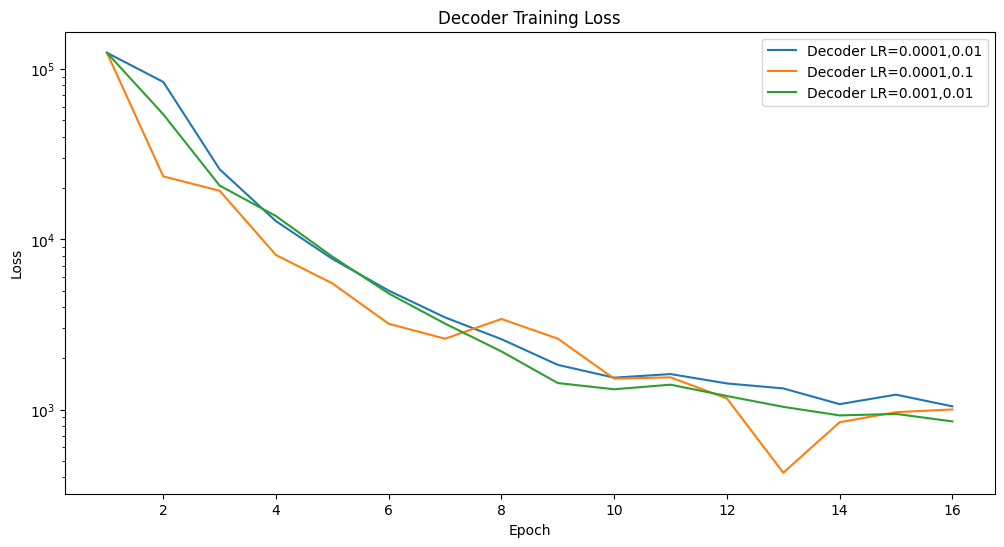

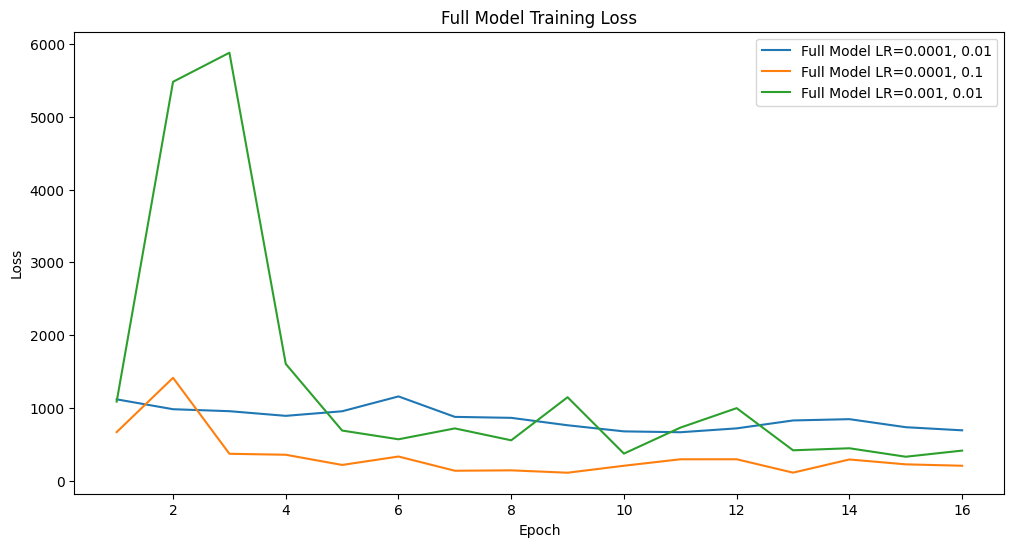

In [ ]:
import matplotlib.pyplot as plt
print(decoder_loss_result)

# Plot decoder loss
plt.figure(figsize=(12, 6))
for i, lr_pair in enumerate(lr_to_test):
    lr_base, lr_max = lr_pair
    plt.plot(range(1, len(decoder_loss_result[0]) + 1), decoder_loss_result[i], label=f'Decoder LR={lr_base},{lr_max}')

plt.title('Decoder Training Loss')
plt.xlabel('Epoch')
plt.yscale('log')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot full model loss
plt.figure(figsize=(12, 6))
for i, lr_pair in enumerate(lr_to_test):
    lr_base, lr_max = lr_pair
    plt.plot(range(1, len(full_loss_result[0]) + 1), full_loss_result[i], label=f'Full Model LR={lr_base}, {lr_max}')

plt.title('Full Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
initial_lr = 0.00001
lr_epochs = 100
optimizer = optim.SGD(model.parameters(), lr=initial_lr)


lr_hist = []
train_loss_history = []

def train_model(n_epochs):
  i = 0
  lr = initial_lr
  for epoch in tqdm(range(n_epochs)):
    # print("epoch:", i)
    for X_batch, y_batch, img_name in train_loader:
      agg_loss = 0
      X_batch = X_batch.permute(0,3,1,2).to(device) # Needs to have shape [batch_size, channels, height, width]
      y_batch = y_batch.to(device)
      y_pred = model(X_batch)
      loss = loss_fn(y_pred,y_batch)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      agg_loss += loss.item()
      train_loss_history.append(agg_loss)

      lr_hist.append(lr)

      lr = 1.1*lr
      for g in optimizer.param_groups:
        g['lr'] = lr
      if lr >= 0.0005:
        break

train_model(3)




In [ ]:
plt.figure(figsize=(10, 5))
plt.xscale('log')  # Set the y-axis to a logarithmic scale

plt.plot(lr_hist,train_loss_history, label='Train Loss')
plt.xlabel('LR')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()  # Add a legend to differentiate between train and validation loss
plt.show()
print(train_loss_history)
print(lr_hist)

In [ ]:
plt.figure(figsize=(10, 5))
#plt.yscale('log')  # Set the y-axis to a logarithmic scale
plt.plot(test_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()  # Add a legend to differentiate between train and validation loss
plt.show()
print(val_accuracy_history)

In [ ]:
#print a trainset with predicted label
# train_loader = DataLoader(data_loader, batch_size=1, shuffle=True, num_workers=1)

train_iter = iter(train_loader)

batch = next(train_iter)

X_batch, y_batch, _ = batch

image = batch[0][0]
labels = batch[1][0]

# Get predicted labels
X_batch = X_batch.permute(0,3,1,2).to(device)
pred = model(X_batch)
print(image.shape)
plot_img_and_boundingbox(image, labels)
plot_img_and_boundingbox(image, pred[0])

In [ ]:
# Print a validation image with its predicted labels

validationloader = DataLoader(test_loader, batch_size=1, shuffle=True, num_workers=1)

validationloader_iter = iter(validationloader)

batch = next(validationloader_iter)

X_batch, y_batch, _ = batch
print(X_batch.shape)
print(y_batch.shape)

image = batch[0][0]
labels = batch[1][0]

# Get predicted labels
X_batch = X_batch.permute(0,3,1,2).to(device)
print(X_batch.shape)
pred = model(X_batch)

plot_img_and_boundingbox(image, labels)

In [ ]:
plot_img_and_boundingbox(image,pred[0])
print(pred)
print(calculate_true_positives_in_batch(labels.view(1,4),pred[0].view(1,4))) # Need to change view since we dont have batch